In [19]:
import sqlite3
import pandas as pd
import os
from collections import OrderedDict
from datetime import datetime
DB = "/media/cap/extra_work/road_model/OBSTABLE"

features_cols = ['TROAD', 'T2m', 'Td2m', 'D10m', 'S10m', 'AccPcp12h']



In [2]:
# Define column types
column_types = {
  #'index': 'int64',  # Assuming this is the reset index column
  'valid_dttm': 'datetime64[ns]',  # For datetime columns
  'SID': 'int64',
  'lat': 'float64',
  'lon': 'float64',
  'TROAD': 'float64',
  'T2m': 'float64',
  'Td2m': 'float64',
  'D10m': 'float64',
  'S10m': 'float64',
  'AccPcp12h': 'float64'
}



In [3]:
def load_and_resample_data(variables, year, interval='30T'):
    dataframes = []

    for variable in variables:
        # Connect to the SQLite database for each variable
        conn = sqlite3.connect(os.path.join(DB, f'OBSTABLE_{variable}_{year}.sqlite'))

        # Use PRAGMA to optimize performance
        conn.execute('PRAGMA synchronous = OFF')
        conn.execute('PRAGMA journal_mode = MEMORY')

        query = f"SELECT valid_dttm, SID, lat, lon, {variable} FROM SYNOP"

        # Read data in chunks
        for chunk in pd.read_sql_query(query, conn, chunksize=10000):
            # Convert Unix time to datetime
            chunk['valid_dttm'] = pd.to_datetime(chunk['valid_dttm'], unit='s')
            chunk = chunk.sort_values(by="valid_dttm")
            dataframes.append(chunk)

        conn.close()

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(dataframes, ignore_index=True)

    # Set 'valid_dttm' as the index for resampling
    full_df.set_index('valid_dttm', inplace=True)

    # Resample data for each station
    resampled_dataframes = []
    for sid, group in full_df.groupby('SID'):
        # Resample the group to the specified interval
        resampled_group = group.resample(interval).first()
        # Forward fill to handle missing data
        resampled_group.ffill(inplace=True)
        resampled_dataframes.append(resampled_group)

    # Combine all resampled dataframes
    resampled_df = pd.concat(resampled_dataframes).reset_index()
    resampled_df = resampled_df.astype(column_types)
    return resampled_df


In [8]:
def load_data(variables, year, station):
    dataframes = []

    for variable in variables:
        # Connect to the SQLite database for each variable
        conn = sqlite3.connect(os.path.join(DB, f'OBSTABLE_{variable}_{year}.sqlite'))

        # Use PRAGMA to optimize performance
        conn.execute('PRAGMA synchronous = OFF')
        conn.execute('PRAGMA journal_mode = MEMORY')

        query = f"SELECT valid_dttm, SID, lat, lon, {variable} FROM SYNOP WHERE SID = {station}"

        # Read data in chunks
        for chunk in pd.read_sql_query(query, conn, chunksize=10000):
            # Convert Unix time to datetime
            chunk['valid_dttm'] = pd.to_datetime(chunk['valid_dttm'], unit='s')
            chunk = chunk.sort_values(by="valid_dttm")
            dataframes.append(chunk)

        conn.close()

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(dataframes, ignore_index=True)

    # Set 'valid_dttm' as the index for resampling
    full_df.set_index('valid_dttm', inplace=True)

    return full_df


In [9]:
variables = ['TROAD', 'T2m', 'Td2m', 'D10m', 'S10m', 'AccPcp12h']


In [10]:
# Define the variables and year
#variables = ['TROAD', 'T2m', 'Td2m', 'D10m', 'S10m', 'AccPcp12h']
#year = 2023
#interval = '30T'  # Resample interval (e.g., '30T' for 30 minutes, '1H' for 1 hour)
#interval = '1h'  # Resample interval (e.g., '30T' for 30 minutes, '1H' for 1 hour)
#resampled_years=OrderedDict()
# Load and resample data
#for year in [2022,2023]:
#    resampled_years[year] = load_and_resample_data(variables, year, interval)


In [11]:
full_years=OrderedDict()
for year in [2022,2023]:
    full_years[year] = load_data(variables,year,180400)

/tmp/ipykernel_48884/3699035743.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(dataframes, ignore_index=True)
/tmp/ipykernel_48884/3699035743.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(dataframes, ignore_index=True)


In [8]:
#SID_sel = 180400

In [21]:
sel_year = full_years[2023] #[full_years[2023].SID == SID_sel]
sel_year

,SID,lat,lon,TROAD,T2m,Td2m,D10m,S10m,AccPcp12h
valid_dttm,,,,,,,,,
2023-12-21 14:00:00,180400,55.619794,12.669695,5.4,NaN,NaN,NaN,NaN,NaN
2023-12-21 15:00:00,180400,55.619794,12.669695,4.6,NaN,NaN,NaN,NaN,NaN
2023-12-21 16:00:00,180400,55.619794,12.669695,3.5,NaN,NaN,NaN,NaN,NaN
2023-12-21 17:00:00,180400,55.619794,12.669695,3.4,NaN,NaN,NaN,NaN,NaN
2023-12-21 18:00:00,180400,55.619794,12.669695,3.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-12-31 18:00:00,180400,55.619794,12.669695,4.6,NaN,NaN,NaN,NaN,NaN
2023-12-31 19:00:00,180400,55.619794,12.669695,4.6,NaN,NaN,NaN,NaN,NaN
2023-12-31 20:00:00,180400,55.619794,12.669695,4.7,NaN,NaN,NaN,NaN,NaN


In [20]:
sel_year[sel_year.index > datetime(2023,1,1) & sel_year.index < datetime(2023,1,5)]

TypeError: unsupported operand type(s) for &: 'datetime.datetime' and 'DatetimeArray'

In [10]:
#resampled_years[2023][resampled_years[2023].SID == SID_sel]

In [13]:
df_tp = load_data(['AccPcp12h'],2023)

In [14]:
df_tp

,SID,lat,lon,AccPcp12h
valid_dttm,,,,
2023-02-20 13:00:00,130100,55.779028,12.121427,14.84
2023-02-15 16:00:00,130100,55.779028,12.121427,2.41
2023-02-16 04:00:00,130100,55.779028,12.121427,2.41
2023-02-18 00:00:00,130100,55.779028,12.121427,12.05
2023-02-19 05:00:00,130100,55.779028,12.121427,12.05
...,...,...,...,...
2023-12-20 10:00:00,130000,55.782998,12.280158,188.02
2023-12-20 11:00:00,130000,55.782998,12.280158,188.07
2023-12-06 10:00:00,130000,55.782998,12.280158,171.56


In [15]:
df_tp = df_tp.sort_values(by="valid_dttm")

In [16]:
df_tp

,SID,lat,lon,AccPcp12h
valid_dttm,,,,
2023-01-31 21:00:00,342000,55.183890,10.673460,14.652
2023-01-31 21:00:00,401400,56.132484,10.141903,0.000
2023-01-31 21:00:00,100600,55.802922,12.533482,0.000
2023-01-31 21:00:00,400900,56.264366,10.611515,0.000
2023-01-31 21:00:00,303700,55.197650,8.727020,33.570
...,...,...,...,...
2023-12-31 22:00:00,234000,55.257370,14.763354,77.460
2023-12-31 22:00:00,501300,56.102188,8.716480,0.000
2023-12-31 22:00:00,400900,56.264366,10.611515,0.080


In [17]:
df_tp[df_tp.SID == 342000]

,SID,lat,lon,AccPcp12h
valid_dttm,,,,
2023-01-31 21:00:00,342000,55.18389,10.67346,14.65200
2023-01-31 22:00:00,342000,55.18389,10.67346,14.89620
2023-01-31 23:00:00,342000,55.18389,10.67346,14.89620
2023-02-01 00:00:00,342000,55.18389,10.67346,14.89620
2023-02-01 01:00:00,342000,55.18389,10.67346,14.89620
...,...,...,...,...
2023-12-31 18:00:00,342000,55.18389,10.67346,9.03541
2023-12-31 19:00:00,342000,55.18389,10.67346,11.47740
2023-12-31 20:00:00,342000,55.18389,10.67346,13.43100


In [18]:
df_troad = load_data(['TROAD'],2023)

In [19]:
df_troad

,SID,lat,lon,TROAD
valid_dttm,,,,
2023-01-21 04:00:00,432900,55.913060,9.273100,-1.43
2023-01-20 17:00:00,432900,55.913060,9.273100,-0.81
2023-01-20 16:00:00,432900,55.913060,9.273100,0.06
2023-01-20 15:00:00,432900,55.913060,9.273100,1.25
2023-01-20 14:00:00,432900,55.913060,9.273100,2.81
...,...,...,...,...
2023-12-24 12:00:00,622800,56.990965,8.447003,6.80
2023-12-26 02:00:00,622800,56.990965,8.447003,2.50
2023-12-17 06:00:00,622800,56.990965,8.447003,8.00


In [20]:
df_troad = df_troad.sort_values(by="valid_dttm")

In [21]:
df_troad[df_troad.SID == 342000]

,SID,lat,lon,TROAD
valid_dttm,,,,
2023-01-11 02:00:00,342000,55.18389,10.67346,4.48718
2023-01-11 03:00:00,342000,55.18389,10.67346,4.81685
2023-01-11 04:00:00,342000,55.18389,10.67346,5.29304
2023-01-11 05:00:00,342000,55.18389,10.67346,5.69597
2023-01-11 06:00:00,342000,55.18389,10.67346,6.20879
...,...,...,...,...
2023-12-31 18:00:00,342000,55.18389,10.67346,4.59707
2023-12-31 19:00:00,342000,55.18389,10.67346,4.70696
2023-12-31 20:00:00,342000,55.18389,10.67346,4.70696


<Axes: xlabel='valid_dttm'>

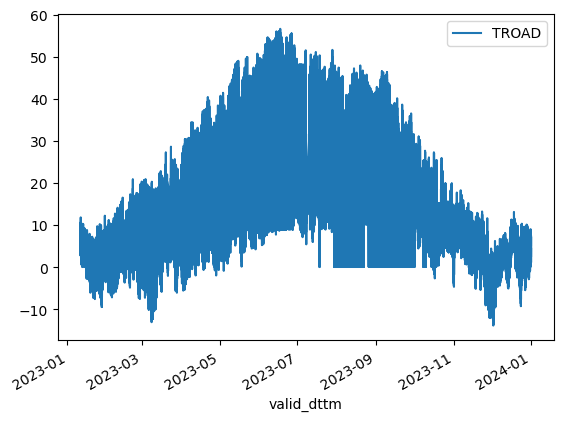

In [24]:
df_troad.plot(y="TROAD")


<Axes: xlabel='valid_dttm'>

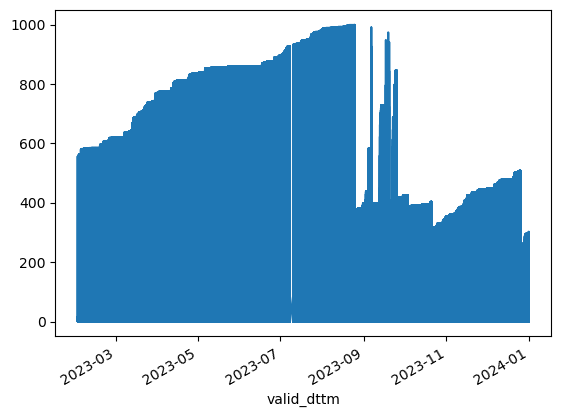

In [25]:
df_tp["AccPcp12h"].plot()

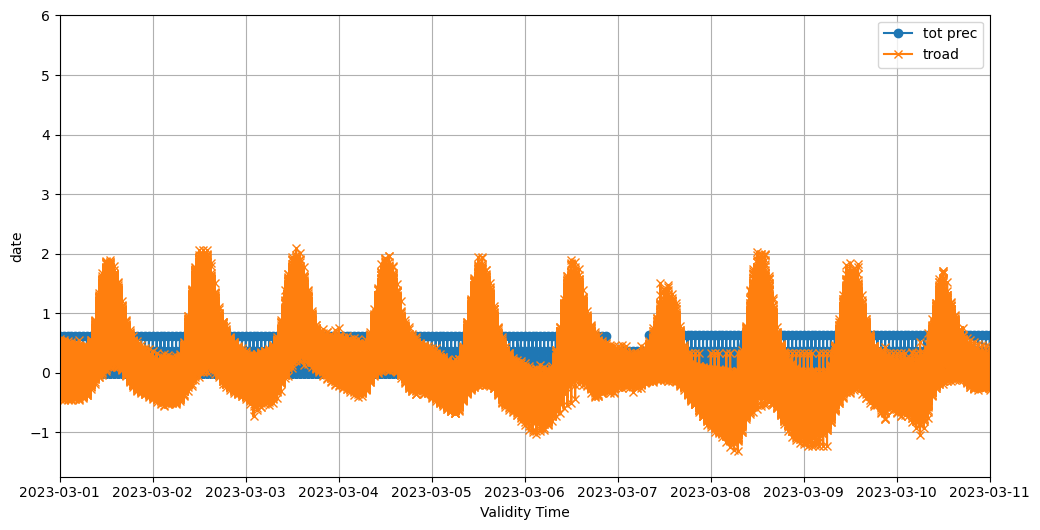

In [33]:
from matplotlib import pyplot as plt
from datetime import datetime
# Plotting the time series
plt.figure(figsize=(12, 6))

plt.plot(df_tp.index, df_tp['AccPcp12h']/1000, label='tot prec', marker='o')
plt.plot( df_troad.index,df_troad["TROAD"]/10, label='troad', marker='x')

plt.xlabel('Validity Time')
plt.ylabel('date')
plt.xlim(datetime(2023,3,1), datetime(2023,3,11))  # Sets x-axis range from 2 to 8

#plt.title('Observed vs Forecast vs Corrected Forecast Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
pd.__version__

'2.2.2'

In [23]:
def load_data(variables, year, station):
  dataframes = []

  for variable in variables:
      conn = sqlite3.connect(os.path.join(DB, f'OBSTABLE_{variable}_{year}.sqlite'))
      conn.execute('PRAGMA synchronous = OFF')
      conn.execute('PRAGMA journal_mode = MEMORY')

      query = f"SELECT valid_dttm, SID, lat, lon, {variable} FROM SYNOP WHERE SID = {station}"

      # Read and process chunks
      for chunk in pd.read_sql_query(query, conn, chunksize=10000):
          chunk['valid_dttm'] = pd.to_datetime(chunk['valid_dttm'], unit='s')
          chunk = chunk.sort_values(by="valid_dttm")
          # Only append non-empty chunks
          if not chunk.empty:
              dataframes.append(chunk)

      conn.close()

  # Filter out empty DataFrames and concatenate
  non_empty_dfs = [df for df in dataframes if not df.empty]
  if non_empty_dfs:
      full_df = pd.concat(non_empty_dfs, ignore_index=True)
      full_df.set_index('valid_dttm', inplace=True)
      return full_df
  else:
      return pd.DataFrame()  # Return empty DataFrame if all chunks were empty

In [26]:
variables = ['TROAD', 'T2m', 'Td2m', 'D10m', 'S10m', 'AccPcp12h']

df = load_data(variables,year,180400)

In [27]:
df

,SID,lat,lon,TROAD
valid_dttm,,,,
2023-12-21 14:00:00,180400,55.619794,12.669695,5.4
2023-12-21 15:00:00,180400,55.619794,12.669695,4.6
2023-12-21 16:00:00,180400,55.619794,12.669695,3.5
2023-12-21 17:00:00,180400,55.619794,12.669695,3.4
2023-12-21 18:00:00,180400,55.619794,12.669695,3.5
...,...,...,...,...
2023-12-31 18:00:00,180400,55.619794,12.669695,4.6
2023-12-31 19:00:00,180400,55.619794,12.669695,4.6
2023-12-31 20:00:00,180400,55.619794,12.669695,4.7
